# Fine-tuning YOLO11 on an License Plate Detection dataset
Fine-tuning YOLO11 on a license plate detection dataset.

by Gholamreza Dar 2024

In [1]:
!pip install -qU ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00


## Huggingface Stuff

In [51]:
# Huggingface login and helper functions
HF_REPO_ID = "Gholamreza/yolo11_license_plate_detection"

from google.colab import userdata
import huggingface_hub
from huggingface_hub import login, hf_hub_download, HfApi

def save_to_hub(file_name, file_in_repo_name=None, repo_id=HF_REPO_ID):
    if file_in_repo_name == None:
        file_in_repo_name = file_name

    api = HfApi()
    api.upload_file(
        path_or_fileobj=file_name,
        path_in_repo=file_in_repo_name,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f">> Uploaded {file_name} to {repo_id}/{file_in_repo_name}")

def save_folder_to_hub(folder_name, repo_id=HF_REPO_ID):
    api = HfApi()
    api.upload_folder(
        folder_path=folder_name,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f">> Uploaded {folder_name} to {repo_id}/{folder_name}")

def load_from_hub(folder_in_repo, repo_id=HF_REPO_ID):
    return hf_hub_download(repo_id=repo_id, filename=folder_in_repo)

login(token=userdata.get('HF_TOKEN'))

## Download and prepare the data

Dataset: [license-plate-detector](https://universe.roboflow.com/mochoye/license-plate-detector-ogxxg) on roboflow universe

Also there is another bigger [dataset](https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e) available

In [52]:
from roboflow import Roboflow
from google.colab import userdata

token = userdata.get('RF_TOKEN')
rf = Roboflow(api_key=token)
project = rf.workspace("mochoye").project("license-plate-detector-ogxxg")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [53]:
# what is the size of the dataset in MB
!du -sh {dataset.location}

23M	/content/License-Plate-Detector-2


In [54]:
print("name:", dataset.name)
print("version:", dataset.version)
print("model_format:", dataset.model_format)
print("location:", dataset.location) # we need this later

name: License Plate Detector
version: 2
model_format: yolov11
location: /content/License-Plate-Detector-2


In [55]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['LicensePlate']

roboflow:
  workspace: mochoye
  project: license-plate-detector-ogxxg
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/mochoye/license-plate-detector-ogxxg/dataset/2

## Fine-tune the model

In [56]:
from ultralytics import YOLO
import os

# Load a pretrained YOLOv11 model
model = YOLO('yolo11n.pt')

# Fine-tune the model using the dataset
results = model.train(
    data=os.path.join(dataset.location, "data.yaml"),
    epochs=100,
    imgsz=640,
    # save_period=5,
    name='yolo11n_anpr',
    fraction=1,
    val=True,
    plots=True,
)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/License-Plate-Detector-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_anpr, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 27.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/License-Plate-Detector-2/train/labels... 277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 277/277 [00:00<00:00, 1926.43it/s]

train: New cache created: /content/License-Plate-Detector-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/License-Plate-Detector-2/valid/labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:00<00:00, 1311.25it/s]

val: New cache created: /content/License-Plate-Detector-2/valid/labels.cache


Plotting labels to runs/detect/yolo11n_anpr/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11n_anpr
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.53G      1.136      3.323      1.228          9        640: 100%|██████████| 18/18 [00:11<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         81         81    0.00333          1      0.783      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.4G      1.002      2.044      1.068         11        640: 100%|██████████| 18/18 [00:04<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         81         81          1      0.345      0.714      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.41G     0.9923       1.75      1.064         10        640: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

                   all         81         81          1      0.241      0.615      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.41G      1.059      1.678      1.102         11        640: 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         81         81      0.767      0.609      0.765      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.41G      1.135       1.66      1.124          7        640: 100%|██████████| 18/18 [00:06<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         81         81      0.448       0.63      0.585      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.41G      1.061       1.56      1.122          7        640: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         81         81      0.738      0.765      0.831      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.41G      1.176      1.532      1.197          7        640: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         81         81      0.652      0.617        0.7      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.41G      1.071      1.387      1.113         11        640: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         81         81      0.738       0.79      0.764      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.41G      1.076      1.324      1.113          6        640: 100%|██████████| 18/18 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         81         81      0.509      0.667      0.622      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.41G      1.053      1.212      1.109         11        640: 100%|██████████| 18/18 [00:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

                   all         81         81       0.87      0.824      0.917      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.41G       1.01      1.138      1.086          9        640: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         81         81      0.606       0.55      0.585      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.41G      1.004       1.08      1.075          9        640: 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         81         81      0.413      0.506      0.452      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.41G     0.9622     0.9702       1.07          7        640: 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

                   all         81         81       0.75      0.741      0.835      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.41G      1.013     0.9718      1.082         10        640: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         81         81      0.792       0.84      0.885      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.41G     0.9412     0.9159      1.047          8        640: 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         81         81      0.902      0.963      0.962      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.41G     0.9478     0.8899      1.065         11        640: 100%|██████████| 18/18 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


                   all         81         81      0.928      0.949      0.973      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.41G     0.9817     0.9053      1.085          4        640: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

                   all         81         81      0.963      0.966      0.977      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.41G     0.9082     0.8083      1.045          8        640: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         81         81      0.973      0.938      0.981      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.41G      0.924     0.7826      1.068          8        640: 100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         81         81      0.976      0.987      0.983      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.41G     0.9579     0.7805      1.078          7        640: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         81         81      0.938      0.988      0.982      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.41G     0.9735     0.8107      1.067          6        640: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         81         81      0.944      0.963      0.979      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.41G     0.9213     0.7494      1.063          5        640: 100%|██████████| 18/18 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         81         81      0.898      0.978      0.966      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.41G     0.9139     0.7573      1.057          9        640: 100%|██████████| 18/18 [00:07<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         81         81      0.974      0.922      0.979      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.41G      0.875     0.7008      1.021          8        640: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         81         81      0.961      0.938      0.973      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.4G     0.8914     0.7572      1.039          4        640: 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

                   all         81         81      0.974      0.934      0.977      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.41G     0.8635     0.7163       1.03          7        640: 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         81         81       0.94      0.963      0.977      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.41G     0.8516      0.681      1.014         10        640: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         81         81      0.975      0.948      0.975      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.41G     0.9123     0.7153      1.049          5        640: 100%|██████████| 18/18 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         81         81      0.931      0.963      0.972      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.41G     0.8248      0.641     0.9873          7        640: 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

                   all         81         81      0.963      0.972      0.973      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.41G     0.8667     0.7019       1.03          4        640: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         81         81      0.999      0.963      0.984      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.41G     0.8576     0.6494      1.023          5        640: 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]

                   all         81         81      0.968      0.988      0.984       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.41G     0.8544     0.6728      1.014          7        640: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         81         81      0.951      0.988      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.41G     0.8317     0.6463     0.9928          7        640: 100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         81         81      0.995      0.951      0.984      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.41G     0.8835     0.6627      1.008         12        640: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         81         81      0.957      0.951      0.978      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.41G     0.8583     0.6442       1.02          7        640: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         81         81      0.991      0.963      0.985      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.41G     0.8453     0.6453      1.014          8        640: 100%|██████████| 18/18 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         81         81      0.988      0.976      0.985      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.41G     0.8107     0.6385      1.009          8        640: 100%|██████████| 18/18 [00:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         81         81       0.98      0.975      0.982      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.41G     0.8022     0.6601     0.9939         12        640: 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         81         81      0.997      0.975      0.985      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.4G     0.7684     0.5764     0.9813          6        640: 100%|██████████| 18/18 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         81         81      0.998      0.951       0.98       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.41G     0.8278     0.5795       1.02         10        640: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         81         81      0.997      0.938      0.979      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.41G     0.7943     0.5795     0.9856         14        640: 100%|██████████| 18/18 [00:06<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         81         81          1      0.942      0.972      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.41G     0.7847     0.5649     0.9882          7        640: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         81         81      0.998      0.975      0.977      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.41G     0.7669      0.563      1.018          9        640: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         81         81      0.987      0.975      0.977       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.41G     0.7667     0.5635     0.9651         10        640: 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         81         81      0.984      0.963      0.979      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.41G     0.7547     0.5678     0.9731          6        640: 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         81         81      0.972      0.975      0.984      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.4G     0.7544     0.5801       1.01          4        640: 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         81         81      0.998      0.975      0.986       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.41G       0.77     0.5673      1.016          6        640: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         81         81      0.999      0.975      0.985      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.41G     0.8275     0.5951      1.037         14        640: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         81         81      0.985      0.963      0.984      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.41G     0.7454     0.5488     0.9845          7        640: 100%|██████████| 18/18 [00:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         81         81      0.975      0.957      0.982      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.41G     0.7584     0.5475     0.9825         10        640: 100%|██████████| 18/18 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all         81         81      0.998      0.963      0.983      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.41G      0.763     0.5465     0.9538          8        640: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         81         81      0.981      0.975      0.982      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.41G     0.8009     0.5651      1.011          6        640: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         81         81      0.971      0.975      0.984      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.41G     0.7131      0.546     0.9453          4        640: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         81         81      0.987      0.973      0.985      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.41G     0.7336     0.5365     0.9921         11        640: 100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         81         81      0.968      0.975      0.982      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.41G     0.7227     0.5403     0.9651          9        640: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         81         81      0.959      0.975      0.982      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.41G      0.717     0.5272     0.9646          8        640: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         81         81          1      0.959      0.983      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.41G      0.699     0.4822     0.9569         12        640: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all         81         81      0.957      0.975      0.981      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.41G     0.7175     0.5037     0.9642          8        640: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         81         81      0.963      0.975      0.982      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.41G     0.6794     0.4836     0.9557          8        640: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         81         81      0.985      0.975      0.977      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.41G     0.6986     0.4982     0.9462         12        640: 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         81         81      0.988      0.963      0.977      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.41G     0.6834     0.5028     0.9681          6        640: 100%|██████████| 18/18 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


                   all         81         81      0.997      0.963      0.976      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.41G     0.6845     0.4783     0.9557         11        640: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         81         81      0.987      0.975      0.979      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.41G     0.6577     0.4654      0.942          7        640: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         81         81      0.983      0.975      0.983      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.41G     0.6898      0.478     0.9764          5        640: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         81         81      0.987      0.975      0.983      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.41G     0.6504     0.4579     0.9308          9        640: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

                   all         81         81      0.997      0.975      0.984      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.41G      0.712     0.4918     0.9543         10        640: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         81         81      0.997      0.975      0.979       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.41G     0.6926     0.4806      0.971          7        640: 100%|██████████| 18/18 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         81         81      0.986      0.975      0.982      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.41G      0.687      0.481     0.9404          5        640: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         81         81      0.987      0.973      0.972      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.41G     0.6662     0.4468     0.9382          8        640: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         81         81       0.97      0.975      0.976      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.41G      0.735     0.5278      1.019          9        640: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         81         81      0.975      0.972      0.984      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.41G     0.6694     0.4953     0.9407         11        640: 100%|██████████| 18/18 [00:06<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

                   all         81         81      0.974      0.975      0.979      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.41G     0.6443     0.4669     0.9376         10        640: 100%|██████████| 18/18 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         81         81      0.975      0.975      0.979       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.41G     0.6476     0.4637     0.9438          7        640: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all         81         81      0.975      0.973      0.984      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.4G     0.6524     0.4596     0.9515          6        640: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         81         81      0.962      0.975      0.984      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.41G     0.6582     0.4446     0.9414          7        640: 100%|██████████| 18/18 [00:05<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         81         81      0.975      0.975      0.984      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.41G     0.5946     0.4325     0.9106         11        640: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         81         81      0.987      0.961      0.979      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.41G     0.6614     0.4525     0.9432          6        640: 100%|██████████| 18/18 [00:04<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         81         81      0.987      0.963      0.978      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.41G     0.6379     0.4587     0.9415          7        640: 100%|██████████| 18/18 [00:07<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         81         81      0.963      0.973      0.977      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.41G     0.6232     0.4275     0.9197          7        640: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

                   all         81         81      0.962      0.975      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.4G     0.6301     0.4414     0.9378          7        640: 100%|██████████| 18/18 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         81         81      0.987      0.972       0.98      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.41G     0.5951     0.4341     0.9246         10        640: 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         81         81      0.986      0.975      0.981      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.41G     0.6088     0.4165     0.8951          7        640: 100%|██████████| 18/18 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         81         81      0.986      0.975      0.982      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.41G     0.6166     0.4236      0.918         12        640: 100%|██████████| 18/18 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         81         81      0.987      0.975      0.982      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.41G     0.5833     0.4174     0.9091          7        640: 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

                   all         81         81      0.974      0.975      0.982      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.41G     0.5819     0.4026     0.9152          9        640: 100%|██████████| 18/18 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

                   all         81         81      0.975      0.975      0.983      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.41G     0.6373     0.4527     0.9616          7        640: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all         81         81      0.973      0.975      0.985      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.41G     0.6062     0.4239     0.9189          7        640: 100%|██████████| 18/18 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         81         81      0.974      0.975      0.984      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.41G     0.5736     0.4111     0.9257          9        640: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all         81         81      0.986      0.963      0.983      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.41G     0.5912     0.4209     0.9311          7        640: 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         81         81      0.987      0.974      0.984      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.4G     0.5868     0.4044     0.9207          4        640: 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         81         81      0.987      0.974      0.981      0.866


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.47G     0.5194     0.3397     0.8573          5        640: 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         81         81      0.997      0.963      0.979      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.4G       0.55     0.3561     0.8938          5        640: 100%|██████████| 18/18 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         81         81      0.999      0.963       0.98      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.4G      0.493     0.3432     0.8635          5        640: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         81         81      0.987      0.974      0.981      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.4G     0.5054     0.3525     0.8729          5        640: 100%|██████████| 18/18 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         81         81      0.987      0.974      0.981      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.4G     0.4779     0.3304     0.8421          5        640: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         81         81      0.987      0.974      0.982      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.4G      0.491     0.3354     0.8716          5        640: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         81         81      0.987      0.975      0.983      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.4G     0.5133       0.35     0.8767          5        640: 100%|██████████| 18/18 [00:07<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         81         81      0.987      0.975      0.983      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.4G     0.4706     0.3257     0.8587          5        640: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all         81         81      0.987      0.975      0.983      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.4G     0.4801     0.3329     0.8629          5        640: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         81         81      0.987      0.975      0.982      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.4G      0.489      0.348     0.8792          5        640: 100%|██████████| 18/18 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         81         81      0.987      0.975      0.983      0.872



100 epochs completed in 0.204 hours.
Optimizer stripped from runs/detect/yolo11n_anpr/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_anpr/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_anpr/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


                   all         81         81      0.987      0.975      0.983       0.88
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/yolo11n_anpr


In [57]:
save_folder_to_hub("runs")

best.pt:   0%|          | 0.00/5.48M [00:00<?, ?B/s]

events.out.tfevents.1734134750.8c924cde3284.336.0:   0%|          | 0.00/335k [00:00<?, ?B/s]

last.pt:   0%|          | 0.00/5.48M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

>> Uploaded runs to Gholamreza/yolo11_license_plate_detection/runs


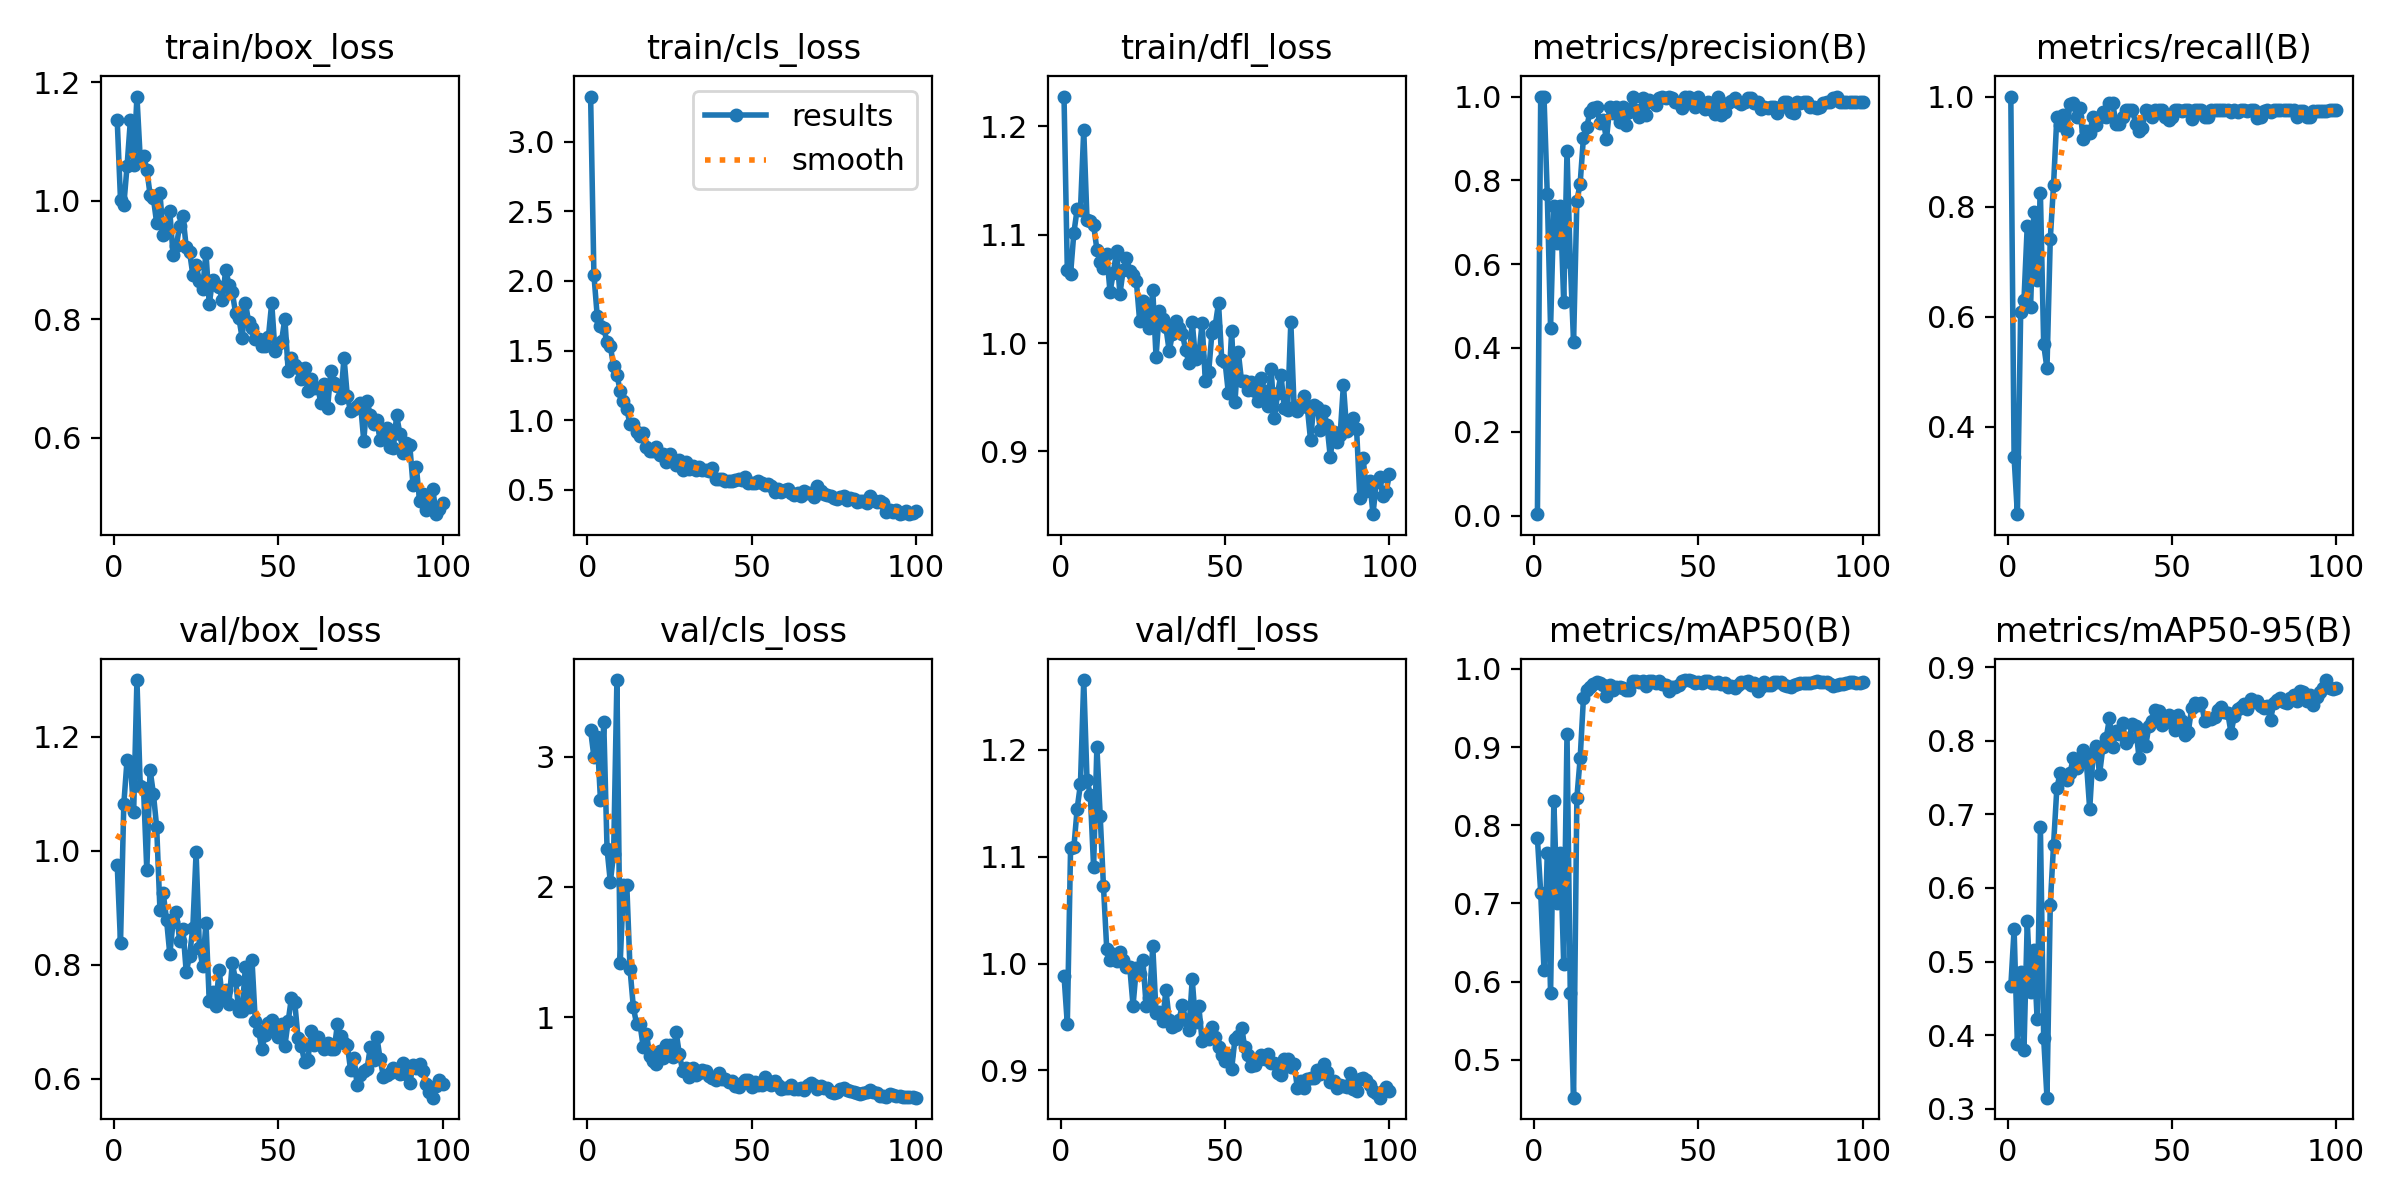

In [58]:
from IPython.display import Image
Image(filename='runs/detect/yolo11n_anpr/results.png', width=1200)

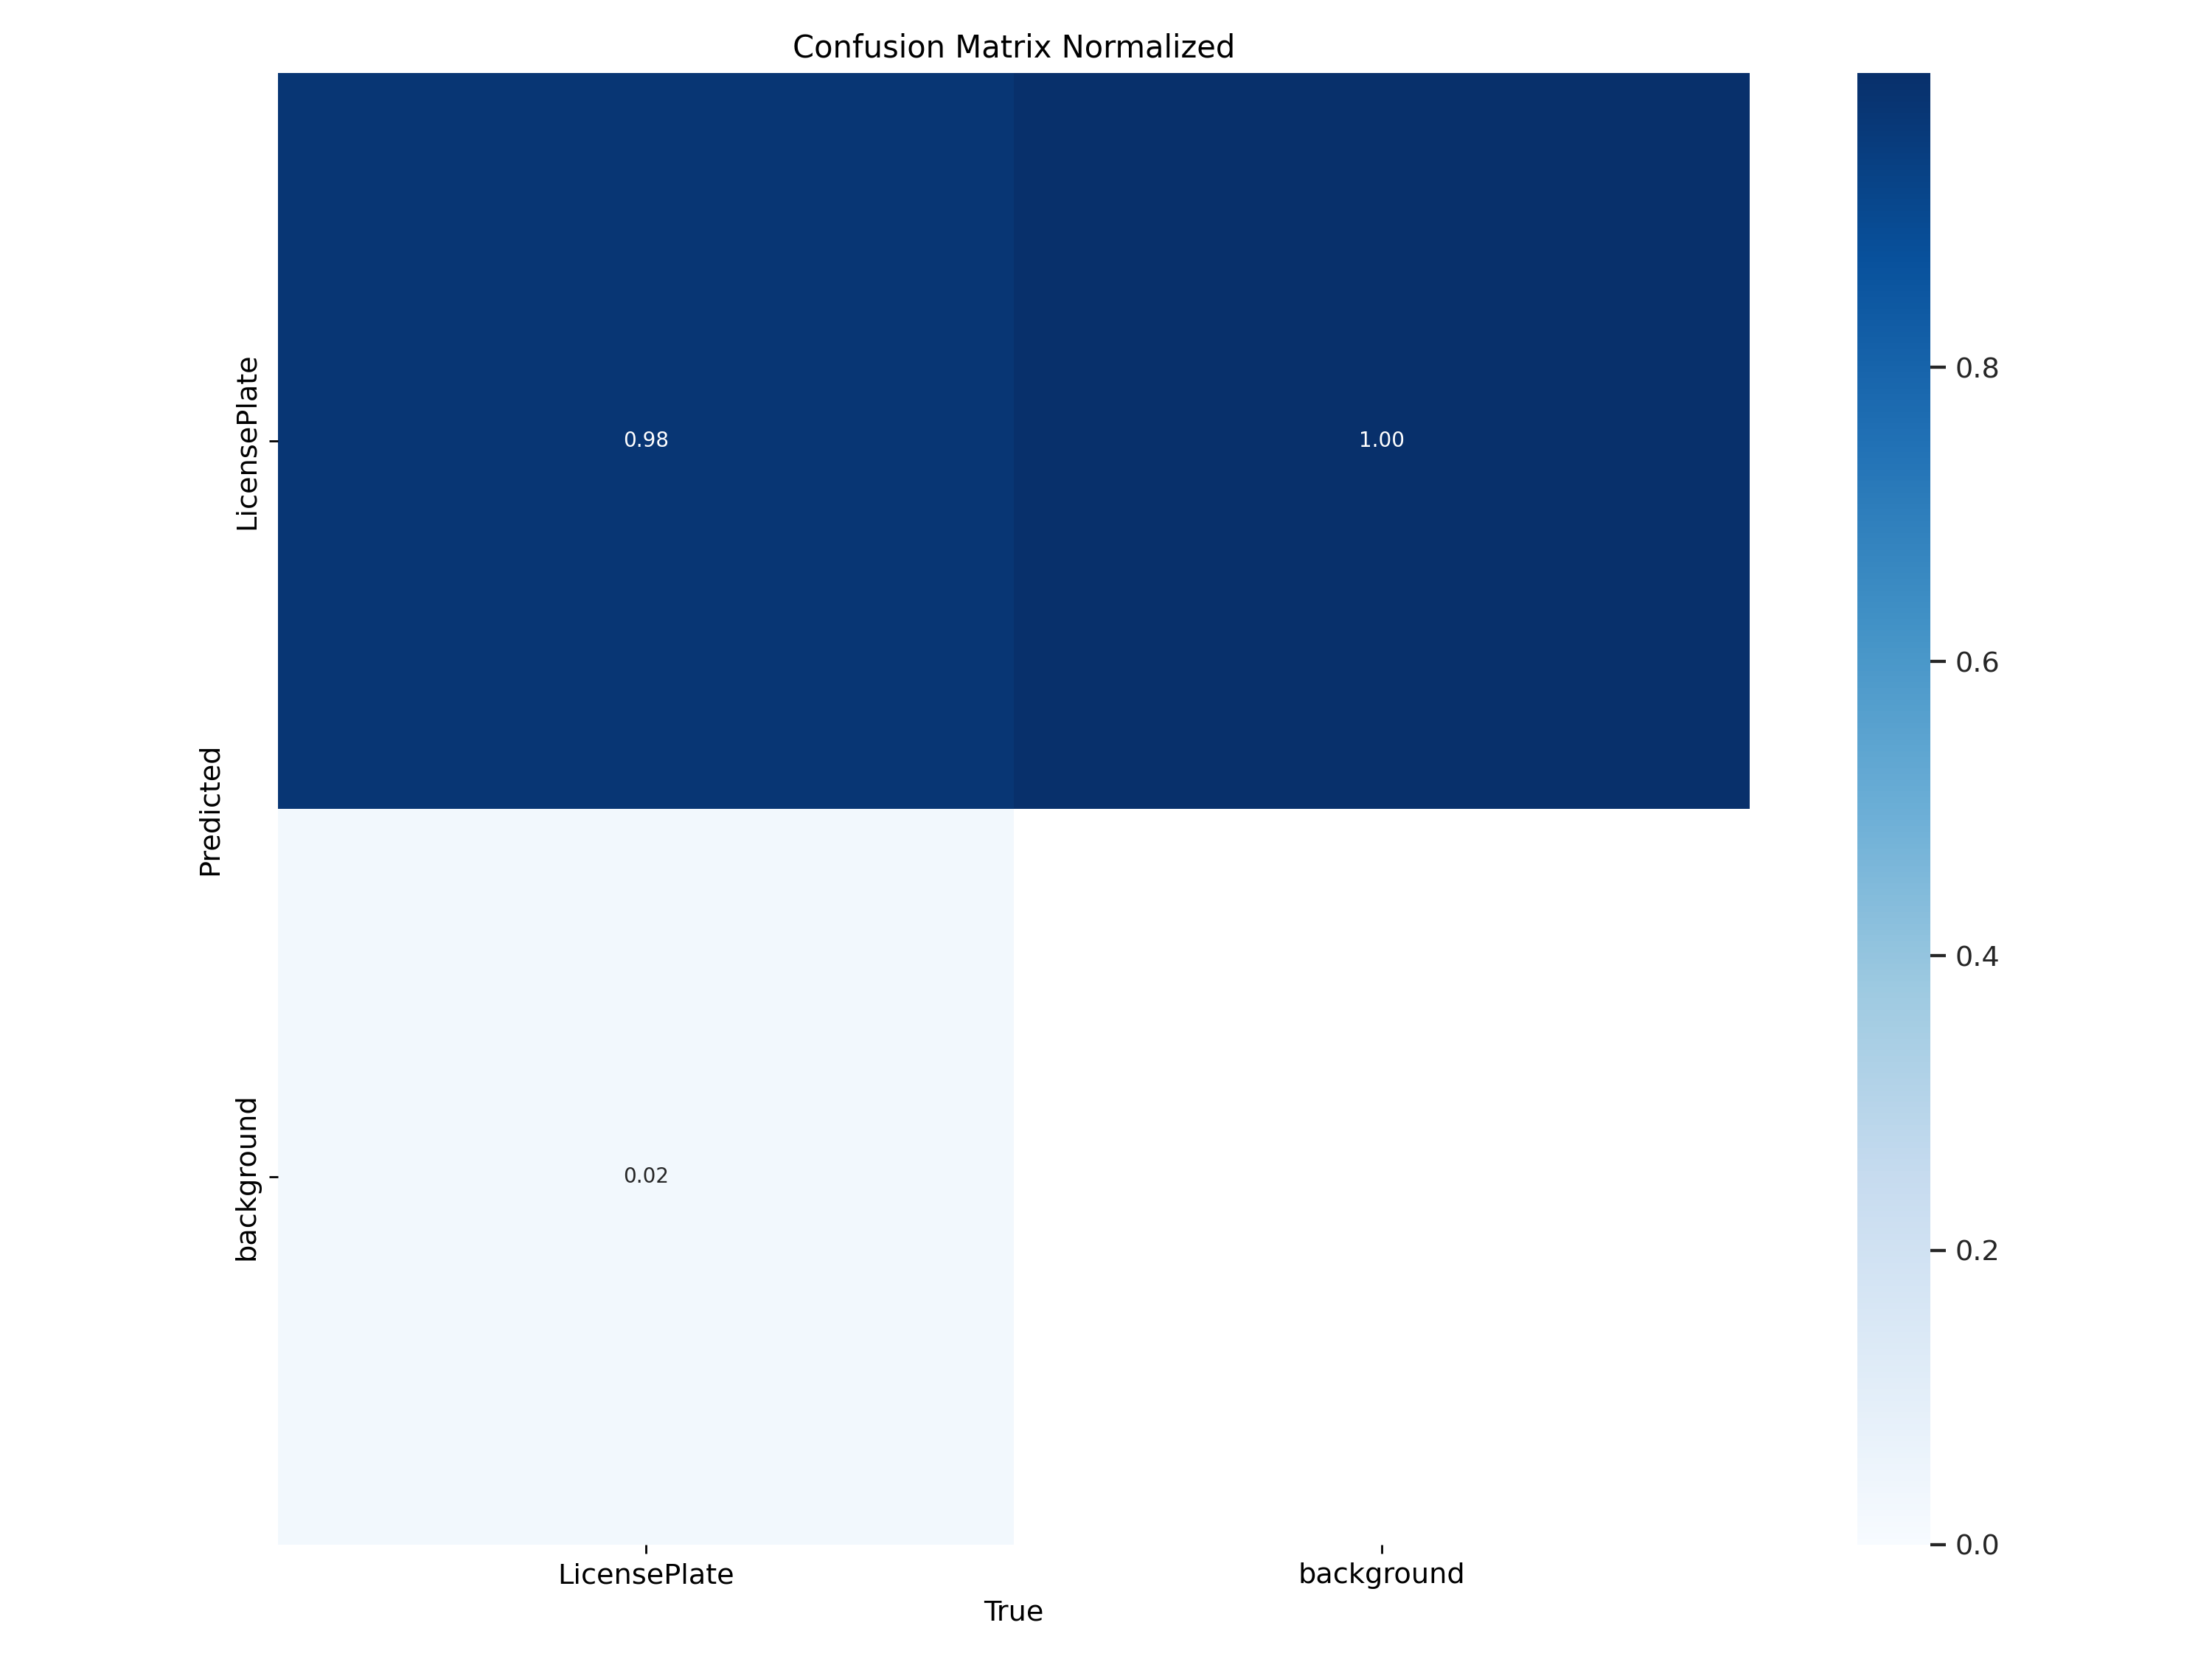

In [59]:
Image(filename='runs/detect/yolo11n_anpr/confusion_matrix_normalized.png', width=1000)

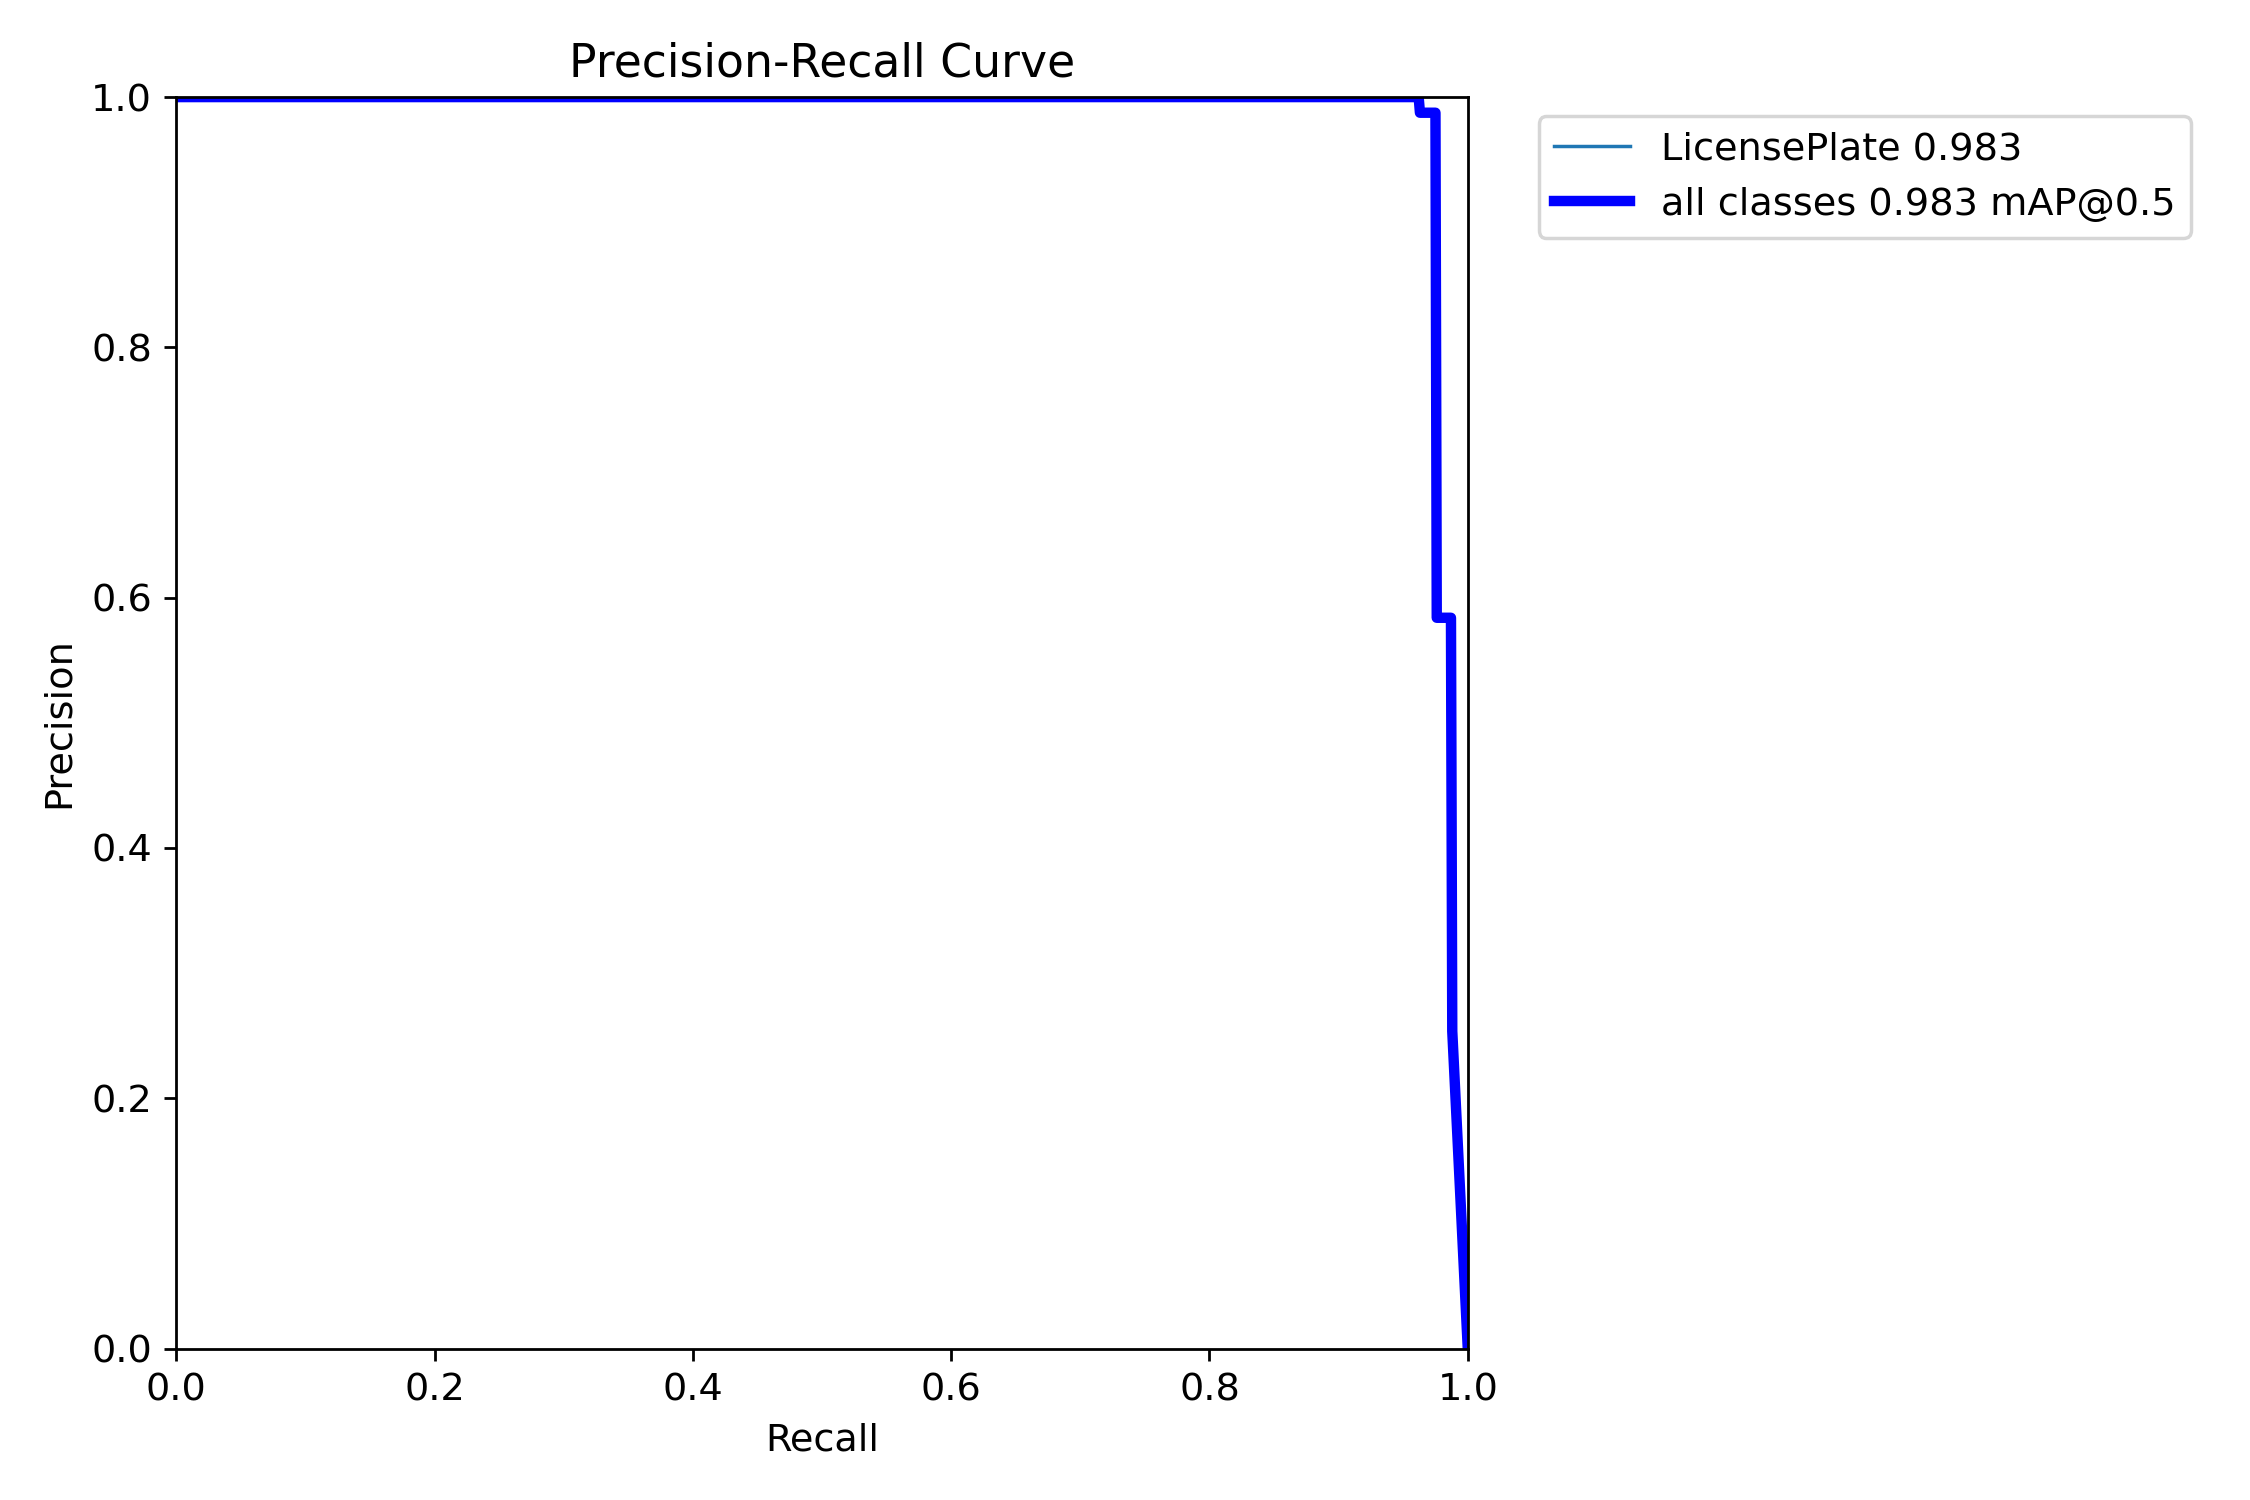

In [60]:
Image(filename='runs/detect/yolo11n_anpr/PR_curve.png', width=600)

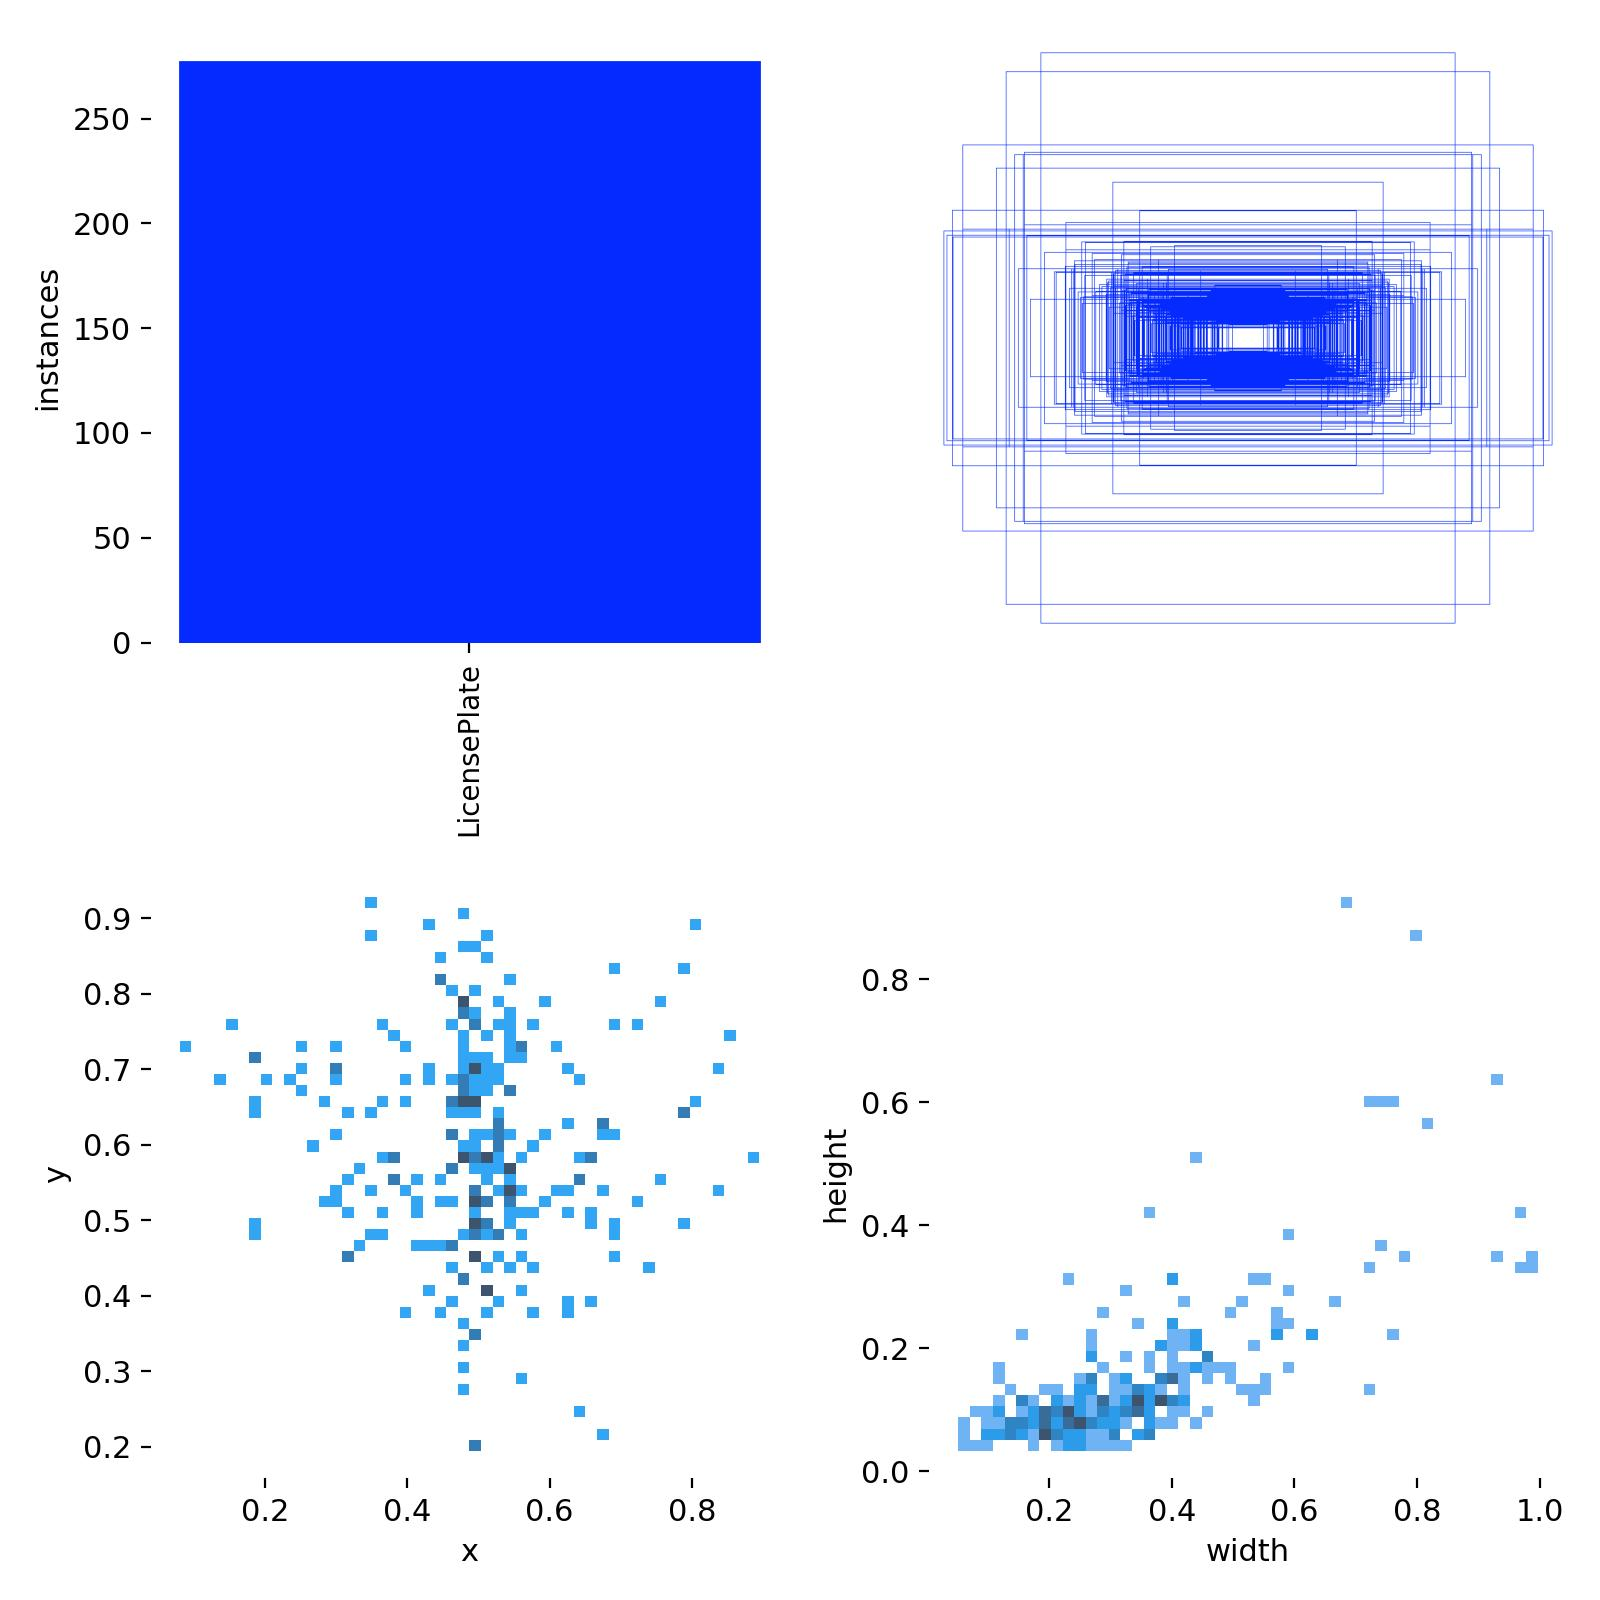

In [61]:
Image(filename='runs/detect/yolo11n_anpr/labels.jpg', width=600)

## Inference


We use this code because the result.show() method of ultralytics uses white color!

In [62]:
import cv2
import matplotlib.pyplot as plt

def show_result_opencv(image_name, result):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Loop through results and draw custom bounding boxes
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
        label = result.names[int(box.cls[0])]  # Get class label
        confidence = box.conf[0]  # Get confidence score

        # Define the bounding box color (BGR format)
        color = (255, 255, 0)  # yellow

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 4)

        text = f"{label} {confidence:.2f}"

        # Get the size of the text box
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX,1, 2)

        # Define the position of the background rectangle
        text_x1, text_y1 = x1, y1 - text_height - baseline
        text_x2, text_y2 = x1 + text_width, y1
        text_x1 -= 2 # fill the gap to the left of the text
        text_y1 -= 4

        # Draw a filled rectangle for the text background
        cv2.rectangle(image, (text_x1, text_y1), (text_x2, text_y2), color, -1)

        # Put the label and confidence score
        cv2.putText(image, text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [63]:
images = ["car_a.jpg", "car_b.jpg", "car_c.jpg", "car_d.jpg"]

results = model(images, save=True)


0: 640x640 1 LicensePlate, 11.2ms
1: 640x640 1 LicensePlate, 11.2ms
2: 640x640 1 LicensePlate, 11.2ms
3: 640x640 2 LicensePlates, 11.2ms
Speed: 3.2ms preprocess, 11.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolo11n_anpr2


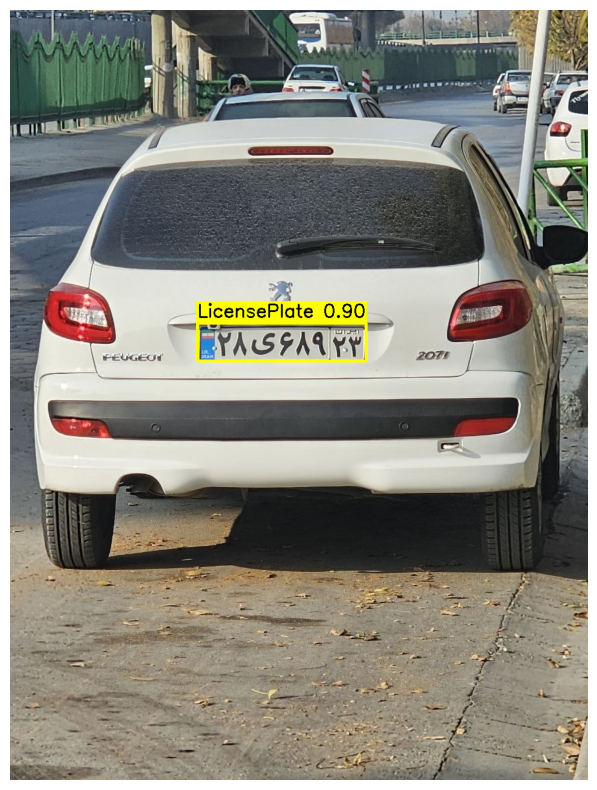

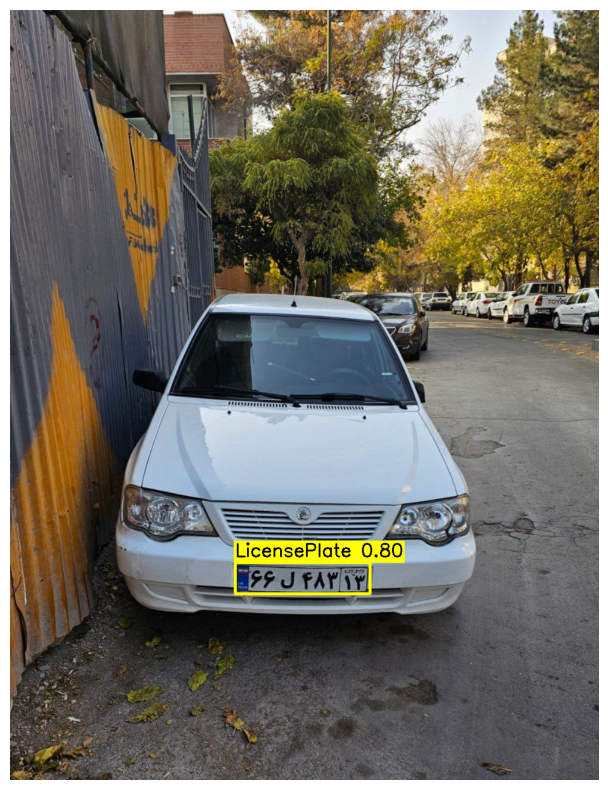

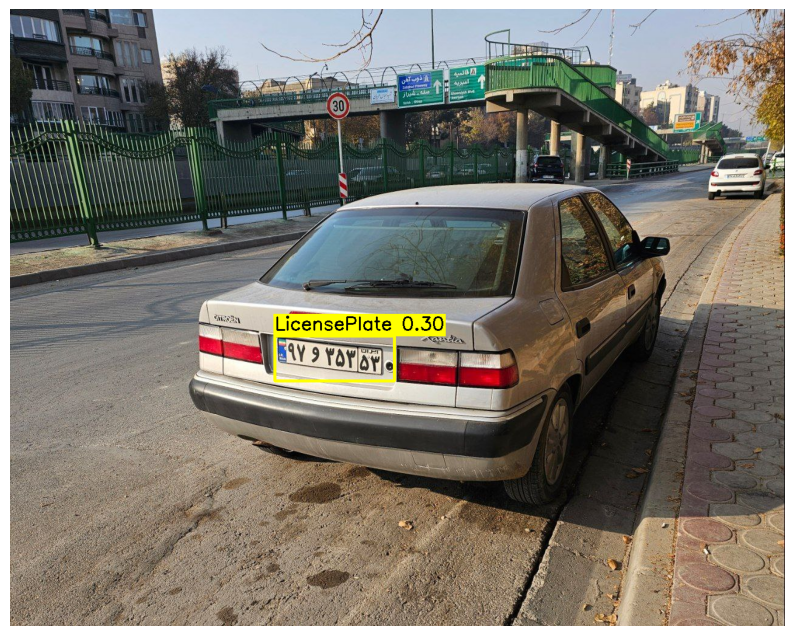

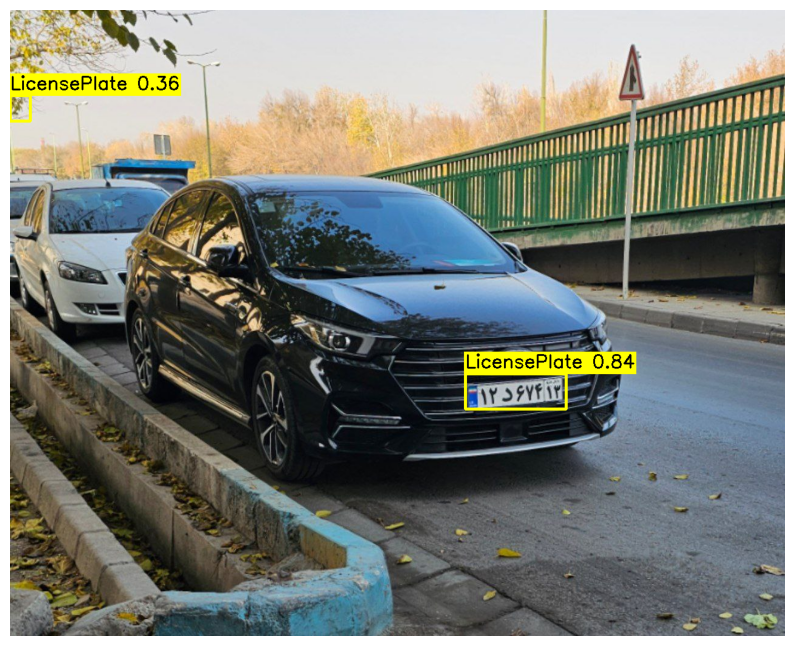

In [64]:
for i in range(len(images)):
    show_result_opencv(images[i], results[i])